<a href="https://colab.research.google.com/github/zkhandker/rupi-kaur/blob/main/Word2vec_LSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies 


In [69]:
# Import Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Download and import the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Import all remaining packages
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
## assert len(tf.config.list_physical_devices('GPU')) > 0
import pathlib

## Load Poems 


In [74]:
path_to_file = tf.keras.utils.get_file('combined2', 'https://raw.githubusercontent.com/zkhandker/rupi-kaur/main/data/combined2.txt')
with open(path_to_file) as f: 
  poems = f.read()
  #print(poems)

## Vectorize Poems 


In [75]:
#sentence = "The wide road shimmered in the hot sun"
tokens = list(poems.lower().split())
print(len(tokens))

13374


In [76]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))


['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [77]:
# Download the "glove-twitter-25" embeddings
glove_vectors = gensim.downloader.load('glove-twitter-25')

# Use the downloaded vectors as usual:
glove_vectors.most_similar('twitter')

[('facebook', 0.9480051398277283),
 ('tweet', 0.9403422474861145),
 ('fb', 0.9342358708381653),
 ('instagram', 0.9104823470115662),
 ('chat', 0.8964964747428894),
 ('hashtag', 0.8885936141014099),
 ('tweets', 0.8878157734870911),
 ('tl', 0.8778461813926697),
 ('link', 0.877821147441864),
 ('internet', 0.8753897547721863)]

In [78]:
glove_vectors["you"]

array([-0.41586 ,  0.32548 , -0.087621,  0.2018  , -0.80017 , -0.34418 ,
        2.1431  ,  0.37188 , -0.9409  ,  0.24283 , -0.86396 ,  0.63858 ,
       -6.0171  , -0.54081 , -0.43305 ,  0.095707,  0.37971 , -1.1432  ,
        0.11382 , -0.38361 ,  0.41758 ,  0.081476, -0.02659 ,  0.75438 ,
       -0.77178 ], dtype=float32)

In [79]:
glove_vectors in glove_vectors.vocab

False

In [80]:
# create a weight matrix for words in training docs
embedding_matrix = []

vocab, index = {}, 0 # start indexing from 0
for token in tokens:
  if (token not in vocab) and (token in glove_vectors.vocab):
    vocab[token] = index
    index += 1
    embedding_vector = glove_vectors[token]
    if embedding_vector is not None:
        embedding_matrix.append(embedding_vector)
vocab_size = len(vocab)
print(vocab)
print(vocab_size)

embedding_matrix=np.array(embedding_matrix)
embedding_matrix.shape

{'how': 0, 'is': 1, 'it': 2, 'so': 3, 'easy': 4, 'for': 5, 'you': 6, 'to': 7, 'be': 8, 'kind': 9, 'people': 10, 'he': 11, 'asked': 12, 'milk': 13, 'and': 14, 'honey': 15, 'dripped': 16, 'from': 17, 'my': 18, 'lips': 19, 'as': 20, 'i': 21, 'answered': 22, 'cause': 23, 'have': 24, 'not': 25, 'been': 26, 'me': 27, 'the': 28, 'first': 29, 'boy': 30, 'that': 31, 'kissed': 32, 'held': 33, 'shoulders': 34, 'down': 35, 'like': 36, 'handlebars': 37, 'of': 38, 'bicycle': 39, 'ever': 40, 'rode': 41, 'was': 42, 'five': 43, 'had': 44, 'smell': 45, 'starvation': 46, 'on': 47, 'his': 48, 'which': 49, 'picked': 50, 'up': 51, 'father': 52, 'feasting': 53, 'mother': 54, 'at': 55, 'a.m.': 56, 'teach': 57, 'body': 58, 'giving': 59, 'those': 60, 'wanted': 61, 'should': 62, 'feel': 63, 'anything': 64, 'less': 65, 'than': 66, 'whole': 67, 'god': 68, 'did': 69, 'empty': 70, 'sex': 71, 'she': 72, 'said': 73, 'but': 74, 'know': 75, 'what': 76, 'making': 77, 'love': 78, 'feels': 79, 'came': 80, 'all': 81, 'this'

(1288, 25)

In [81]:
inverse_vocab = {index: token for token, index in vocab.items()}
print(inverse_vocab)

{0: 'how', 1: 'is', 2: 'it', 3: 'so', 4: 'easy', 5: 'for', 6: 'you', 7: 'to', 8: 'be', 9: 'kind', 10: 'people', 11: 'he', 12: 'asked', 13: 'milk', 14: 'and', 15: 'honey', 16: 'dripped', 17: 'from', 18: 'my', 19: 'lips', 20: 'as', 21: 'i', 22: 'answered', 23: 'cause', 24: 'have', 25: 'not', 26: 'been', 27: 'me', 28: 'the', 29: 'first', 30: 'boy', 31: 'that', 32: 'kissed', 33: 'held', 34: 'shoulders', 35: 'down', 36: 'like', 37: 'handlebars', 38: 'of', 39: 'bicycle', 40: 'ever', 41: 'rode', 42: 'was', 43: 'five', 44: 'had', 45: 'smell', 46: 'starvation', 47: 'on', 48: 'his', 49: 'which', 50: 'picked', 51: 'up', 52: 'father', 53: 'feasting', 54: 'mother', 55: 'at', 56: 'a.m.', 57: 'teach', 58: 'body', 59: 'giving', 60: 'those', 61: 'wanted', 62: 'should', 63: 'feel', 64: 'anything', 65: 'less', 66: 'than', 67: 'whole', 68: 'god', 69: 'did', 70: 'empty', 71: 'sex', 72: 'she', 73: 'said', 74: 'but', 75: 'know', 76: 'what', 77: 'making', 78: 'love', 79: 'feels', 80: 'came', 81: 'all', 82: 't

In [83]:
vectorized_poems = np.array([vocab[word] for word in vocab.keys()])
print(vectorized_poems)

[   0    1    2 ... 1285 1286 1287]


In [84]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(poems[:10]), vectorized_poems[:10]))
# check that vectorized_poems is a numpy array
assert isinstance(vectorized_poems, np.ndarray), "returned result should be a numpy array"

'how is it ' ---- characters mapped to int ----> [0 1 2 3 4 5 6 7 8 9]


## Define Batch 


In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  # input_batch = # TODO
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
  # output_batch = # TODO

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly! 
test_args = (vectorized_poems, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

In [ ]:
x_batch, y_batch = get_batch(vectorized_poems, seq_length=5, batch_size=1)

In [ ]:
print(x_batch)
print(y_batch)

## Define RNN 


In [ ]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [ ]:
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=False)) 


In [87]:
### Defining the RNN Model ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), batch_input_shape=[batch_size, None], trainable=False),

    # Layer 2: LSTM with `rnn_units` number of units. 
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units), 
    # LSTM('''TODO'''),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(vocab_size)
    # '''TODO: DENSE LAYER HERE'''
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=25, rnn_units=1024, batch_size=32)

In [ ]:
len(vocab)

## Test Untrained RNN 


In [88]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (32, None, 25)            32200     
_________________________________________________________________
lstm_2 (LSTM)                (32, None, 1024)          4300800   
_________________________________________________________________
dense_2 (Dense)              (32, None, 1288)          1320200   
Total params: 5,653,200
Trainable params: 5,621,000
Non-trainable params: 32,200
_________________________________________________________________


In [89]:
x, y = get_batch(vectorized_poems, seq_length=10, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 10)  # (batch_size, sequence_length)
Prediction shape:  (32, 10, 1288) # (batch_size, sequence_length, vocab_size)


In [90]:
x[0]

array([331, 332, 333, 334, 335, 336, 337, 338, 339, 340])

In [91]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([1067,  246,  303, 1175,   94, 1178,  573,  423,   33,  558])

In [92]:
print("Input: \n")
for i in x[0]:
  print(inverse_vocab[i])

Input: 

soaking
no
else
way.
taught
needed
credit
warmth
because
felt


In [ ]:
print("Output: \n")
for i in sampled_indices:
  print(inverse_vocab[i])

## Train 


In [97]:
### Defining the loss function ###

'''TODO: define the loss function to compute and return the loss between
    the true labels and predictions (logits). Set the argument from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  # loss = tf.keras.losses.sparse_categorical_crossentropy('''TODO''', '''TODO''', from_logits=True) # TODO
  return loss

'''TODO: compute the loss using the true next characters from the example batch 
    and the predictions from the untrained model several cells above'''
example_batch_loss = compute_loss(y, pred)
# example_batch_loss = compute_loss('''TODO''', '''TODO''') # TODO

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 10, 1288)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       7.164717


In [100]:
### Hyperparameter setting and optimization ###

# Optimization parameters:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 10  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 25 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

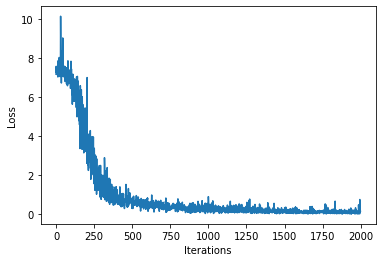

100%|██████████| 2000/2000 [14:10<00:00,  2.35it/s]


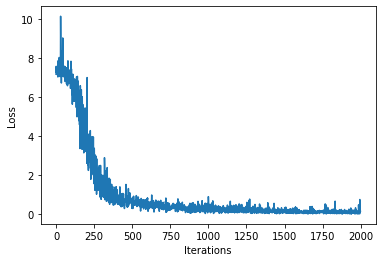

In [101]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
# model = build_model('''TODO: arguments''')

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = # TODO

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x) # TODO
    # y_hat = model('''TODO''')
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat) # TODO
    # loss = compute_loss('''TODO''', '''TODO''')

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables) # TODO
  # grads = tape.gradient('''TODO''', '''TODO''')
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_poems, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

## Generate Poem 


In [102]:
'''TODO: Rebuild the model using a batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) # TODO
# model = build_model('''TODO''', '''TODO''', '''TODO''', batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (1, None, 25)             32200     
_________________________________________________________________
lstm_6 (LSTM)                (1, None, 1024)           4300800   
_________________________________________________________________
dense_6 (Dense)              (1, None, 1288)           1320200   
Total params: 5,653,200
Trainable params: 5,621,000
Non-trainable params: 32,200
_________________________________________________________________


In [103]:
start_string=['i']
input_eval = [vocab[s] for s in start_string]
print(input_eval)

[21]


In [104]:
### Prediction of a generated song ###

def generate_text(model, start_string, generation_length=75):
  # Evaluation step (generating text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [vocab[s] for s in start_string] # TODO
  # input_eval = ['''TODO''']
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      # predictions = model('''TODO''')
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      # predicted_id = tf.random.categorical('''TODO''', num_samples=1)[-1,0].numpy()
      
      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(inverse_vocab[predicted_id]) # TODO 
      # text_generated.append('''TODO''')
    
  return (' '.join(start_string) + ' ' + ' '.join(text_generated))

In [105]:
'''TODO: Use the model and the function defined above to generate ABC format text of length generation_length!'''
generated_text = generate_text(model, start_string=['my','body'], generation_length=50)

100%|██████████| 50/50 [00:00<00:00, 95.37it/s]


In [106]:
print(generated_text)

my body being on. shine gotten good look taken hair secrets them. realize real is. storm hits cowardice sets in. thought replaced by sad reality fighting bone saying find better stand naked half them hidden somewhere inside asking forced intention loving say something along lines all. engulfed existence risk sake out. meant
